# 2008 FAA Flight Data Visualization
## by Gary Cheng


## Dataset Overview

This dataset comes from the Bureau of Transportation Statistics, and contains flight on-time performance data that includes , minutes of arrival/departure delays, flight delay reason, origin/destination airport, airline, whether the flight is cancelled/diverted, flight cancellation reason, and some other flight related attributes for all scheduled domestic flights within the United States in 2008 totalling to roughly 7 million in number.

## Investigation Overview
From a 2010 study in an annual U.S. impact of flight delays, it was found that 

*Flight delay is a serious and widespread problem in the United States. Increasing flight delays place a significant strain on the U.S. air travel system and cost airlines, passengers and society many billions of dollars each year. The 8.3 billion airline component consists of increased expenses for crew, fuel and maintenance, among others. The 16.7 billion passenger component is based on the passenger time lost due to schedule buffer, delayed flights, flight cancellations and missed connections. The 2.2 billion cost from lost demand is an estimate of the welfare loss incurred by passengers who avoid air travel as the result of delays.*

Source: https://www.airlines.org/data/annual-u-s-impact-of-flight-delays-nextor-report/




I want to look at the impact of flight delays in terms of airports, airlines, and scheduled flight times as these factors play a direct role in determining where, where, and how we fly as airline passengers.  The answers to some example questions below may help us mitigate flight delays the next time we fly. 

- Which airports have it worst in terms of flight delays?
- Which airlines have have the best and worse performance in terms of flight delays?

In [36]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
x = np.random.normal(size=100)
with plt.rc_context(dict(sb.axes_style("whitegrid"),
                         **sb.plotting_context("notebook", font_scale=1))):
    sb.kdeplot(x, shade=True)
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [37]:
# load in the dataset into a pandas dataframe
df_08 = pd.read_csv('2008.csv.bz2',compression='bz2')

# read in airport and airline names for later use 
airports = pd.read_csv('airports.csv')
carriers = pd.read_csv('carriers.csv')

In [38]:
# down cast data types to reduce memory usage

df_08['FlightNum'] = df_08['FlightNum'].astype(np.int16)
df_08['CarrierDelay'] = df_08['CarrierDelay'].astype(np.float32)
df_08['WeatherDelay'] = df_08['WeatherDelay'].astype(np.float32)
df_08['NASDelay'] = df_08['NASDelay'].astype(np.float32)
df_08['SecurityDelay'] = df_08['SecurityDelay'].astype(np.float32)
df_08['LateAircraftDelay'] = df_08['LateAircraftDelay'].astype(np.float32)
df_08['Cancelled'] = df_08['Cancelled'].astype(np.int8)
df_08['Diverted'] = df_08['Diverted'].astype(np.int8)
df_08['Distance'] = df_08['Distance'].astype(np.int16)
df_08['TaxiOut'] = df_08['TaxiOut'].astype(np.float32)
df_08['TaxiIn'] = df_08['TaxiIn'].astype(np.float32)
df_08['CRSArrTime'] = df_08['CRSArrTime'].astype(np.int16)
df_08['CRSDepTime'] = df_08['CRSDepTime'].astype(np.int16)
df_08['ArrTime'] = df_08['ArrTime'].astype(np.float32)
df_08['DepTime'] = df_08['DepTime'].astype(np.float32)
df_08['ArrDelay'] = df_08['ArrDelay'].astype(np.float32)
df_08['DepDelay'] = df_08['DepDelay'].astype(np.float32)
df_08['ActualElapsedTime'] = df_08['ActualElapsedTime'].astype(np.float32)
df_08['CRSElapsedTime'] = df_08['CRSElapsedTime'].astype(np.float32)
df_08['AirTime'] = df_08['AirTime'].astype(np.float32)
df_08['CRSDepTime']= df_08['CRSDepTime'].astype(str)
df_08['CRSArrTime']= df_08['CRSArrTime'].astype(str)

In [39]:
# Merge airports and carrier dataframes and include the actual names for airports in new columns 

df_08 = pd.merge(df_08, airports[['iata','airport']], how='left',left_on='Origin', right_on='iata')
df_08 = pd.merge(df_08, airports[['iata','airport']], how='left',left_on='Dest', right_on='iata')

# Merge airport dataframe to get the state where the airport is located in, and put into new columns
df_08 = pd.merge(df_08, airports[['iata','state']], how='left', left_on='Origin', right_on='iata')
df_08 = pd.merge(df_08, airports[['iata','state']], how='left', left_on='Dest', right_on='iata')

# Merge airports and carrier dataframes and include the actual names of unique carriers in new column
df_08 = pd.merge(df_08, carriers, how='left',left_on='UniqueCarrier', right_on='Code')

# Rename newly added columns to appropriate names
df_08.rename(columns={"airport_x": "airport_origin", "airport_y": "airport_dest",
                      "Description":"Airline", 'state_x':'origin_state', 'state_y':'dest_state'}, inplace=True)

# Drop columns that will not be used in the analysis
df_08.drop(columns=['iata_x','iata_y','Code','FlightNum','TailNum','ActualElapsedTime',
                    'CRSElapsedTime','AirTime'],inplace=True)

In [40]:
# Define desired column order
cols = df_08.columns.tolist()

cols = ['Year','Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime','UniqueCarrier',
        'Airline','ArrDelay','DepDelay','Distance','TaxiIn','TaxiOut','Cancelled','CancellationCode','Diverted','CarrierDelay',
        'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','Origin','airport_origin','origin_state',
        'Dest','airport_dest','dest_state']

# Reorder columns
df_08 = df_08[cols]

In [41]:
# Function to the hour from time columns having 24-hour format hhmm
def get_hour(data):
    if len(data) == 4:
        return data[:2]
    elif len(data) == 3:
        return data[:1]
    else:
        return 0

In [42]:
# Insert dep_hour and arr_hour columns to pull hour info from CRSDepTime and CRSArrTime columns
df_08.insert(6, "dep_hour", df_08.CRSDepTime.apply(get_hour)) 
df_08.insert(9, "arr_hour", df_08.CRSArrTime.apply(get_hour)) 

In [43]:
# Convert CRSDeptTime and CRSArrTime to integer
df_08['CRSDepTime']= df_08['CRSDepTime'].astype(np.int16)
df_08['CRSArrTime']= df_08['CRSArrTime'].astype(np.int16)

In [44]:
# Convert to int8
df_08['dep_hour'] = df_08['dep_hour'].astype(np.int8)
df_08['arr_hour'] = df_08['arr_hour'].astype(np.int8)

In [45]:
# Insert DepDate with date type to show the flight date that comprises of year, month, and day in YYYY-mm-dd format
df_08['DepDate'] = pd.to_datetime(df_08.Year*10000 + df_08.Month*100 + df_08.DayofMonth,format='%Y%m%d', errors='ignore')

In [46]:
# Clean up names of airlines by removing Inc. and Co. and any string after
df_08['Airline'] = df_08['Airline'].str.replace(' Inc.*| Co.*', '', regex=True)

In [47]:
# Function to get cancellation reason from cancellation code
def cancel_reason(code):
    if code=='A':
        return 'Carrier'
    elif code=='B':
        return 'Weather'
    elif code=='C':
        return 'NAS'
    elif code=='D':
        return 'Security'

In [48]:
# Replace letter cancellation code with cause of cancellation using cancel_reason function
df_08['CancellationCode'] = df_08['CancellationCode'].apply(cancel_reason)

### Arrival Delay Distribution

Arrival delay has a long tailed distribution, with most of the delay happening at 100 minutes or less.  However there are some really long delays greater than 1500 minutes or 62.5 hours!

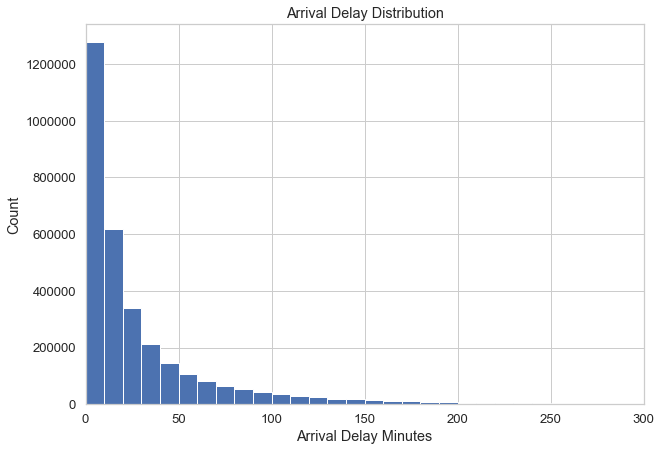

In [74]:
bin_edges = np.arange(0, df_08['ArrDelay'].max()+10, 10)
plt.figure(figsize = [10, 7])
plt.hist(data = df_08, x = 'ArrDelay',bins = bin_edges)
plt.title('Arrival Delay Distribution')
plt.xlabel('Arrival Delay Minutes')
plt.ylabel('Count')
plt.xlim(0, 300);

### Departure Delay Distribution


The departure delay pretty much follows the same distribution pattern as the arrival delay having a long tailed distribution, with most of the delay happening at 60 minutes or less.

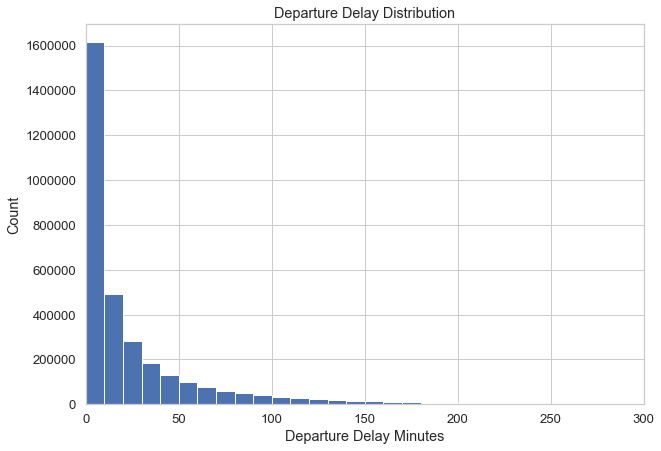

In [73]:
bin_edges = np.arange(0, df_08['DepDelay'].max()+10, 10)
plt.figure(figsize = [10, 7])
plt.hist(data = df_08, x = 'DepDelay',bins = bin_edges)
plt.title('Departure Delay Distribution')
plt.xlabel('Departure Delay Minutes')
plt.ylabel('Count')
plt.xlim(0, 300);

### Overall Percentages of Delayed Flights

FAA considers a flight to be delayed when it is 15 minutes later than its scheduled time.  22.2% and 19.3% of flights experience delays of 15 minutes or more, for arriving and departing flights, respectively.

In [51]:
for x in df_08:
    df_08.loc[df_08['ArrDelay'] < 15, 'arr_status'] = 'Not Delayed'
    df_08.loc[df_08['ArrDelay'] >= 15, 'arr_status'] = 'Delayed'
    df_08.loc[df_08['DepDelay'] < 15, 'dep_status'] = 'Not Delayed'
    df_08.loc[df_08['DepDelay'] >= 15, 'dep_status'] = 'Delayed'

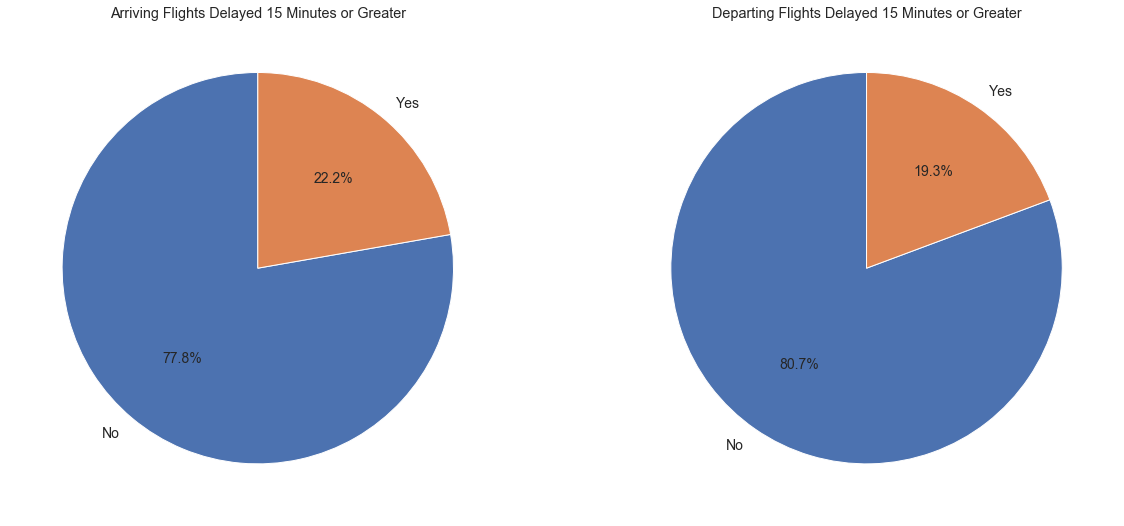

In [52]:
f,ax=plt.subplots(1,2,figsize=(20,9))
df_08['arr_status'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False, labels=['No','Yes'],startangle=90,
                                           textprops={'fontsize': 14})
ax[0].set_title('Arriving Flights Delayed 15 Minutes or Greater')
ax[0].set_ylabel('')

df_08['dep_status'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False, labels=['No','Yes'],startangle=90,
                                           textprops={'fontsize': 14})
ax[1].set_title('Departing Flights Delayed 15 Minutes or Greater')
ax[1].set_ylabel('')

plt.show()

### Top 30 Airports by Number of Scheduled Flights

Next, we will examine both origin and destination aiports in terms of the number of scheduled flights. Below we can see the top 30 airports in terms of number of scheduled flights in 2008, with Atlanta holding on to the #1 spot, followed by Chicago O'Hare and Dallas Fort Worth.

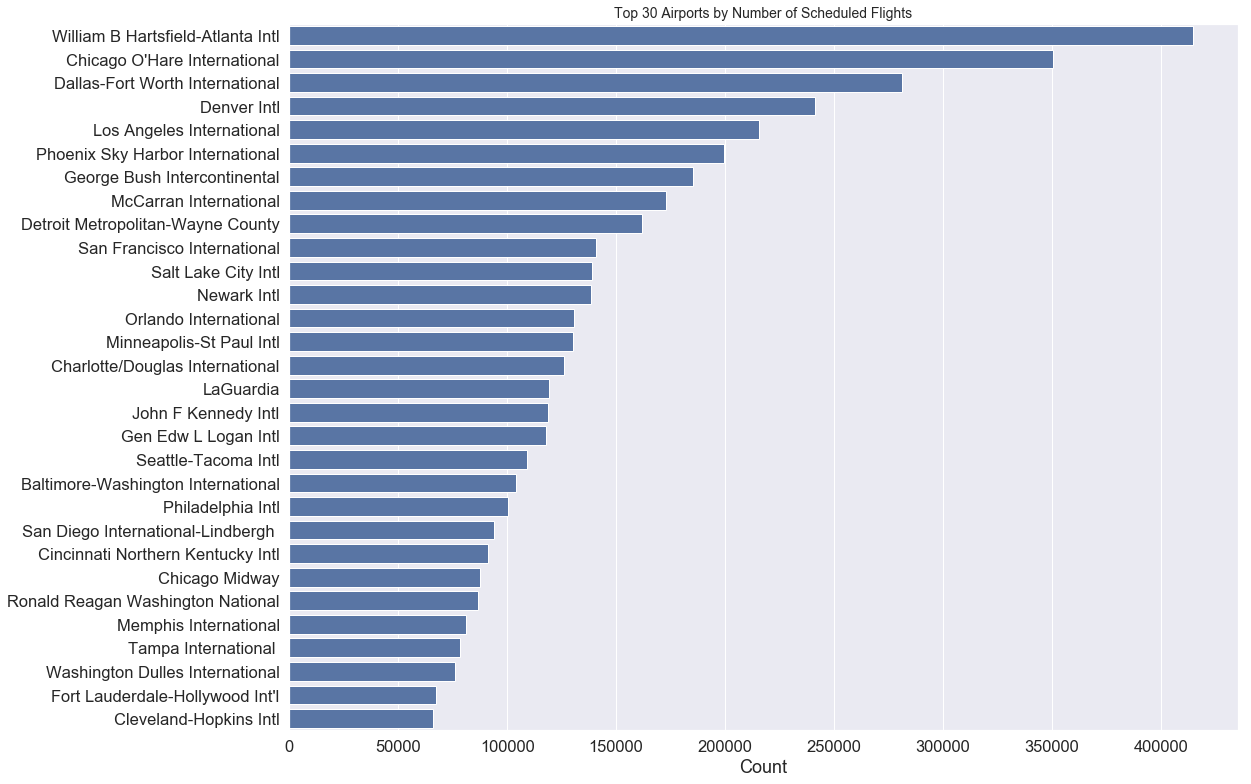

In [100]:
plt.figure(figsize=(17,13))
plt.title('Top 30 Airports by Number of Scheduled Flights')
sb.set(font_scale=1.5)
base_color = sb.color_palette()[0]
ax=sb.countplot(data = df_08, y = 'airport_origin', color = base_color, 
             order=df_08['airport_origin'].value_counts().iloc[:30].index)
ax.set(xlabel='Count', ylabel='')
ax.set_title('Top 30 Airports by Number of Scheduled Flights', fontsize=14)
plt.show();

### What is the best time to fly? (Departure hour)

Here we have a distribution plot of all departing flights during the 24 hour of the day.  There are a suprising amount of departing flights early on during the day at 6am and 7am than what I would expect.  The volume of traffic starts to taper off after 7pm, with almost no flights departing between 1am and 4am.

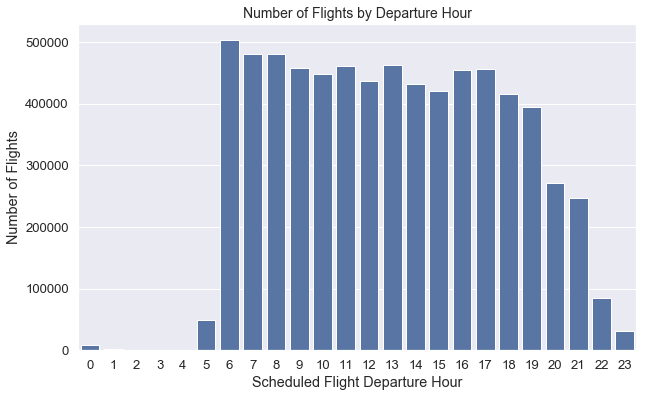

In [91]:
plt.figure(figsize=(10,6))
sb.set(font_scale=1.2)
plt.xlabel('Scheduled Flight Departure Hour')
plt.ylabel('Number of Flights')
base_color = sb.color_palette()[0]
sb.set(style="whitegrid", font_scale=1)
ax = sb.countplot(data = df_08, x = 'dep_hour', color = base_color);
ax.set(xlabel='Scheduled Flight Departure Hour', ylabel='Number of Flights')
ax.set_title('Number of Flights by Departure Hour', fontsize=14)
plt.show()

### What is the best time to fly? (Arrival hour)


The pattern for arriving flights is similar to departure flights.  Notice that we don't see the high amounts of traffic between 6am and 7am as seen for departure flights, but there is a steady traffic volume between 10am and 8pm.  This distributed looks to be shifted compared to the departure hour plot.

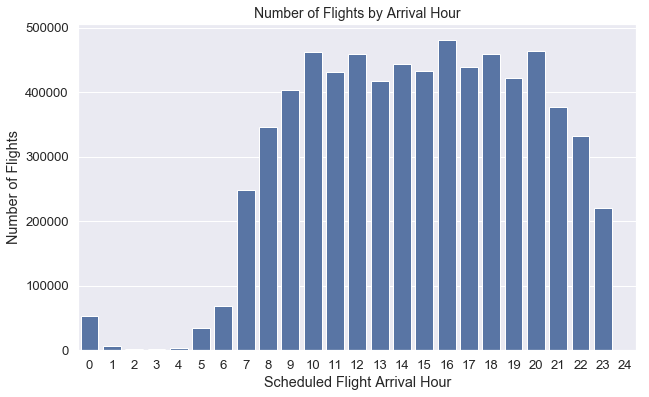

In [93]:
plt.figure(figsize=(10,6))
sb.set(font_scale=1.2)
plt.xlabel('Scheduled Flight Arrival Hour')
plt.ylabel('Number of Flights')
base_color = sb.color_palette()[0]
sb.set(style="whitegrid", font_scale=1)
ax = sb.countplot(data = df_08, x = 'arr_hour', color = base_color);
ax.set(xlabel='Scheduled Flight Arrival Hour', ylabel='Number of Flights')
ax.set_title('Number of Flights by Arrival Hour', fontsize=14)
plt.show()

### Which airline has the most scheduled flights?

Southwest has by far the most number of flights out of all airlines, doubling that of American Airlines.  

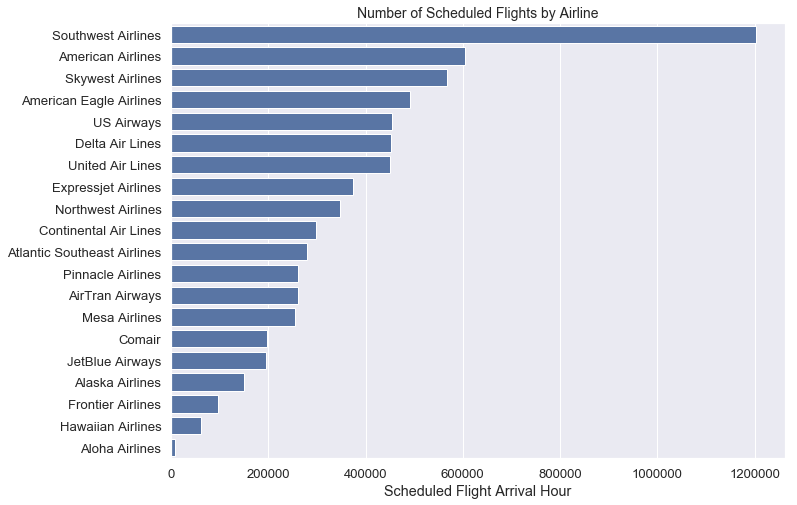

In [96]:
plt.figure(figsize=(11,8))
sb.set(font_scale=1.2)
ax = sb.countplot(data = df_08, y = 'Airline', color = base_color,order=df_08['Airline'].value_counts().index )
ax.set(xlabel='Scheduled Flight Arrival Hour', ylabel='')
ax.set_title('Number of Scheduled Flights by Airline', fontsize=14)
plt.show();


### What are the best and worst months to fly in terms of delays?

As a whole, the amount of delays is the greatest in the month of December, and the least in October.  Weather probably plays a factor in this as 4 of the top 5 months where delay is the greatest occurs between December and March.

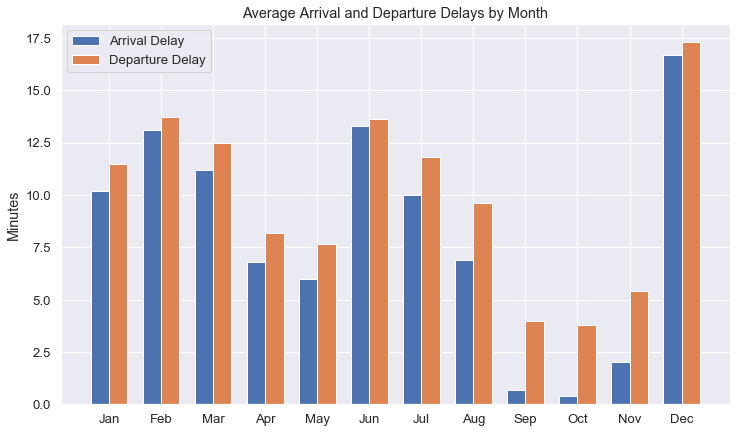

In [57]:
xlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ind = np.arange(len(xlabels)) 
width = 0.35       

plt.figure(figsize = [12, 7])
plt.bar(ind, df_08.groupby(['Month']).mean()['ArrDelay'], width, label='Arrival Delay')
plt.bar(ind + width, df_08.groupby(['Month']).mean()['DepDelay'], width, label='Departure Delay')

plt.ylabel('Minutes')
plt.title('Average Arrival and Departure Delays by Month')

plt.xticks(ind + width / 2, xlabels)
plt.legend(loc='best')
plt.show()

### What day of the week has the most and least amount of delay?

Weekdays have about the same number of scheduled flights, and is what I would expect because of business travellers.  Saturday has the least amount of scheduled flights.

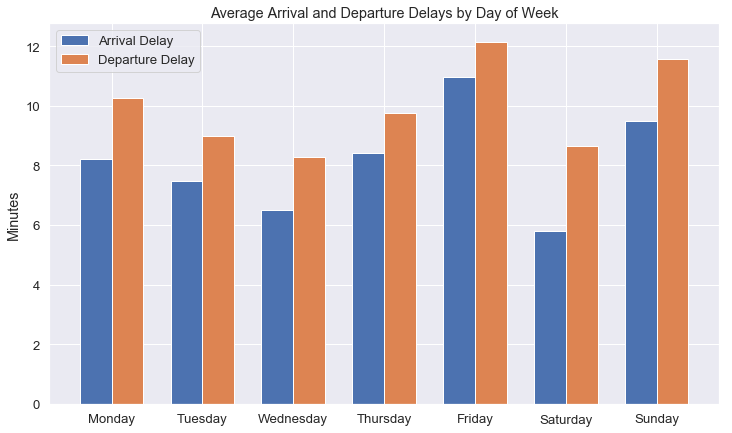

In [58]:
xlabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ind = np.arange(len(xlabels)) 
width = 0.35       

plt.figure(figsize = [12, 7])
plt.bar(ind, df_08.groupby(['DayOfWeek']).mean()['ArrDelay'], width, label='Arrival Delay')
plt.bar(ind + width, df_08.groupby(['DayOfWeek']).mean()['DepDelay'], width, label='Departure Delay')

plt.ylabel('Minutes')
plt.title('Average Arrival and Departure Delays by Day of Week')

plt.xticks(ind + width / 2, xlabels)
plt.legend(loc='best')
plt.show()

### Which hour should you choose to fly to avoid delays?

The worst time in terms of flight delays is between between the hours of 5pm and 8pm, and it also makes sense that the least delay occurs between the 5am and 7am hours.

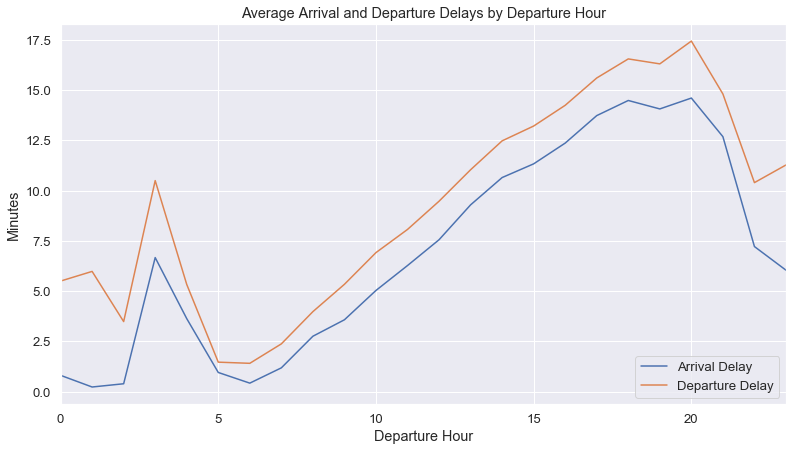

In [59]:
fig, ax = plt.subplots(figsize=(13,7))
df_08.groupby(['dep_hour']).mean()['ArrDelay'].plot(ax=ax)
df_08.groupby(['dep_hour']).mean()['DepDelay'].plot(ax=ax)
plt.title('Average Arrival and Departure Delays by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Minutes')
plt.legend(['Arrival Delay','Departure Delay'], loc='lower right');

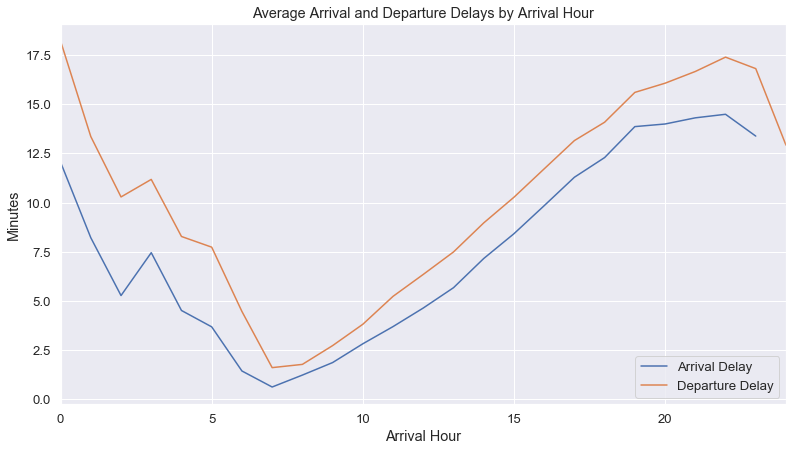

In [60]:
fig, ax = plt.subplots(figsize=(13,7))
df_08.groupby(['arr_hour']).mean()['ArrDelay'].plot(ax=ax)
df_08.groupby(['arr_hour']).mean()['DepDelay'].plot(ax=ax)
plt.title('Average Arrival and Departure Delays by Arrival Hour')
plt.xlabel('Arrival Hour')
plt.ylabel('Minutes')
plt.legend(['Arrival Delay','Departure Delay'], loc='lower right');

In [61]:
def plot_delay_type_old(by,n=10):
   
    # Create df_plot for plotting purposes
    df_plot = df_08.groupby(by)[['CarrierDelay','WeatherDelay','NASDelay',
                          'SecurityDelay','LateAircraftDelay']].mean().reset_index().set_index(by)
    
    # Create new column adding up all cancellation summary values
    df_plot['temp'] = df_plot['CarrierDelay'] + df_plot['WeatherDelay'] + df_plot['NASDelay'] + df_plot['SecurityDelay'] + df_plot['LateAircraftDelay']

    # Sort by descending total number of cancellations in TotalCancel column
    df_plot = df_plot.sort_values(by = 'temp', ascending=False).head(n)

    # Drop the TotalCancel column so it won't be plotted 
    df_plot.drop(columns = 'temp',inplace=True)
    
    # Reverse the dataframe so that the horizontal plot will plot the maximum from top instead of bottom
    df_plot = df_plot.iloc[::-1]
    
    #N = 5
    CDelay = df_plot['CarrierDelay']
    WDelay = df_plot['WeatherDelay']
    NDelay = df_plot['NASDelay']
    SDelay = df_plot['SecurityDelay']
    LDelay = df_plot['LateAircraftDelay']
    #menStd = (2, 3, 4, 1, 2)
    #womenStd = (3, 5, 2, 3, 3)
    ind = np.arange(n)    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence
    
    plt.figure(figsize = [10, 7])
    p1 = plt.barh(ind, CDelay, width)
    p2 = plt.barh(ind, WDelay, width, left=CDelay)
    p3 = plt.barh(ind, NDelay, width, left=WDelay+CDelay)
    p4 = plt.barh(ind, SDelay, width, left=WDelay+CDelay+NDelay)
    p5 = plt.barh(ind, LDelay, width, left=WDelay+CDelay+NDelay+SDelay)

    plt.xlabel('Minutes')
    plt.title('Average Arrival Delay in Minutes with Delay Type')
    plt.yticks(ind, df_plot.index)
    plt.xticks(np.arange(0, 70, 10))
    plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), df_plot.columns, loc='lower right')

    plt.show()

In [62]:
def plot_delay_type(by,busy_airports=False,n=10):
    
    if busy_airports:
        top_n = df_08['airport_dest'].value_counts().iloc[:n].index.tolist()
        busiest_airports = df_08[df_08['airport_dest'].isin(top_n)]
        df_plot = busiest_airports.groupby(by)[['CarrierDelay','WeatherDelay','NASDelay',
                          'SecurityDelay','LateAircraftDelay']].mean().reset_index().set_index(by)
    else:
        # Create df_plot for plotting purposes
        df_plot = df_08.groupby(by)[['CarrierDelay','WeatherDelay','NASDelay',
                          'SecurityDelay','LateAircraftDelay']].mean().reset_index().set_index(by)
    
    # Create new column adding up all cancellation summary values
    df_plot['temp'] = df_plot['CarrierDelay'] + df_plot['WeatherDelay'] + df_plot['NASDelay'] + df_plot['SecurityDelay'] + df_plot['LateAircraftDelay']

    # Sort by descending total number of cancellations in TotalCancel column
    df_plot = df_plot.sort_values(by = 'temp', ascending=False).head(n)

    # Drop the TotalCancel column so it won't be plotted 
    df_plot.drop(columns = 'temp',inplace=True)
    
    # Reverse the dataframe so that the horizontal plot will plot the maximum from top instead of bottom
    df_plot = df_plot.iloc[::-1]
    
    #N = 5
    CDelay = df_plot['CarrierDelay']
    WDelay = df_plot['WeatherDelay']
    NDelay = df_plot['NASDelay']
    SDelay = df_plot['SecurityDelay']
    LDelay = df_plot['LateAircraftDelay']
    
    ind = np.arange(n)    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence
    
    sb.set(style='whitegrid', font_scale=1.2)
    plt.figure(figsize = [10, 7])
    p1 = plt.barh(ind, CDelay, width, color='#003f5c')
    p2 = plt.barh(ind, WDelay, width, left=CDelay, color='#58508d')
    p3 = plt.barh(ind, NDelay, width, left=WDelay+CDelay, color='#bc5090')
    p4 = plt.barh(ind, SDelay, width, left=WDelay+CDelay+NDelay, color='#ff6361')
    p5 = plt.barh(ind, LDelay, width, left=WDelay+CDelay+NDelay+SDelay, color='#ffa600')

    plt.xlabel('Minutes')
    plt.title('Average Arrival Delay in Minutes with Delay Type')
    plt.yticks(ind, df_plot.index)
    plt.xticks(np.arange(0, 70, 10))
    plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), df_plot.columns, loc='lower right')

    plt.show()

### Which airlines suffers from the most amount of arrival delays?

Chances are you will get more delay with JetBlue, though they don't have control of it most of the time.  Your best bet might be to choose Alaska, Hawaiian, Frontier, and Aloha airlines.

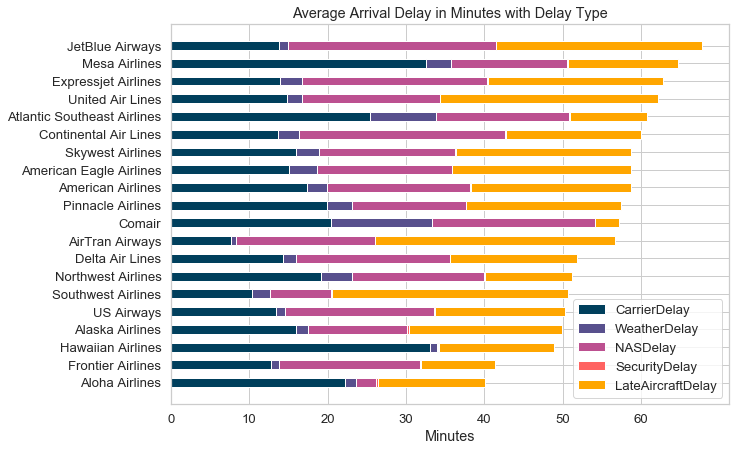

In [63]:
plot_delay_type('Airline',n=df_08.Airline.value_counts().shape[0])

### Which airports suffer the most delays in the US?

Included in the top 20 list are airports with delays sorted in descending order.  Looking at the chart, I don't even know half the airports in the list. Maybe it's more useful to just plot out the top 20 airports in terms of number of scheduled flights.  This may give a better idea of the major airports which affects more passengers overall.

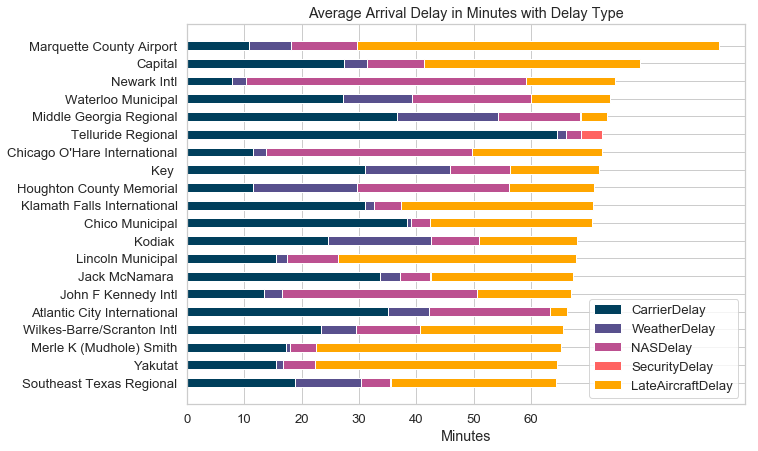

In [64]:
plot_delay_type(by='airport_dest',busy_airports=False,n=20)

### Which of the busiest airports in the US suffer the most delays?

Below we have a plot that only includes the top 20 airports in the US as a subset in terms of number of scheduled flights to give a better picture of the average arrival delays where most people tend to fly to.  Newark, O'Hare, and JFK seem to be notorious ones with the worst delays in the country.  They are also major airline hubs.

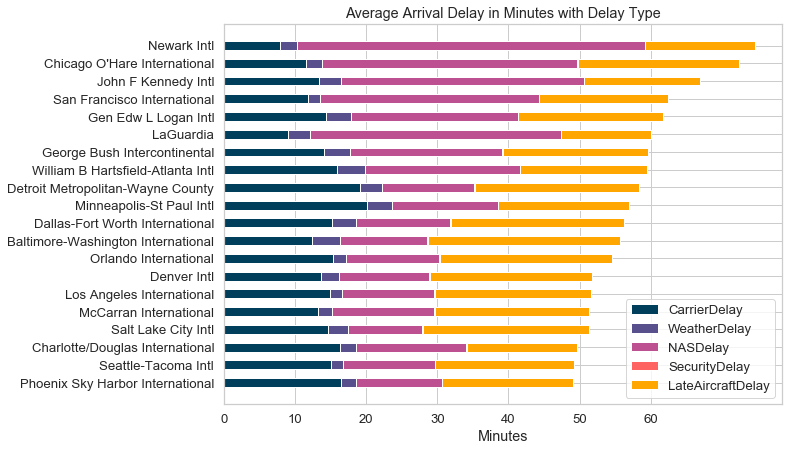

In [65]:
plot_delay_type(by='airport_dest',busy_airports=True,n=20)

In [66]:
def plot_cancel_code(by,n=10,sorted=True, order='top', orientation='h'):     # count default is 10
    # Create df_plot for plotting purposes
    df_plot = df_08.groupby(['CancellationCode', by]).size().reset_index().pivot(columns='CancellationCode',
                                                                                   index=by, values=0)
    # Fill NaN with zeros
    df_plot.fillna(0, inplace = True)

    # Create new column adding up all cancellation summary values
    df_plot['TotalCancel'] = df_plot['Carrier'] + df_plot['NAS'] + df_plot['Security'] + df_plot['Weather']
    
    if sorted and order=='top':
        # Sort by descending total number of cancellations in TotalCancel column
        df_plot = df_plot.sort_values(by = 'TotalCancel',ascending=False).head(n)
    elif sorted and order=='bottom':
        # Sort by ascending total number of cancellations in TotalCancel column
        df_plot = df_plot.sort_values(by = 'TotalCancel',ascending=True).head(n)
    else:
        # Values are not sorted, useful for ordinal variables
        df_plot = df_plot.head(n)
    
    if orientation == 'h':
        # Get maximum value for x axis number so that the axis is labelled with proper range
        x_max = (df_plot['TotalCancel'].iloc[0])
    
        # Drop the TotalCancel column so it won't be plotted 
        df_plot.drop(columns = 'TotalCancel',inplace=True)
    
        # Reverse the dataframe so that the horizontal plot will plot the maximum from top instead of bottom
        df_plot = df_plot.iloc[::-1]
    
        # Generate plot
    
        Carrier = df_plot['Carrier']
        NAS = df_plot['NAS']
        Security = df_plot['Security']
        Weather = df_plot['Weather']
    
        ind = np.arange(n)    # the x locations for the groups
        width = 0.5       # the width of the bars: can also be len(x) sequence
    
        sb.set(style='whitegrid', font_scale=1.2)
        plt.figure(figsize = [10, 7])
        p1 = plt.barh(ind, Carrier, width, color='#004c6d')
        p2 = plt.barh(ind, NAS, width, left=Carrier, color='#5d8ba9')
        p3 = plt.barh(ind, Security, width, left=Carrier+NAS, color='#8eb8d3')
        p4 = plt.barh(ind, Weather, width, left=Carrier+NAS+Security, color='#c1e7ff')

        plt.xlabel('Count')
        plt.title('Number of Flight Cancellations')
        
        if by == 'Month':
            ylabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ylabels.reverse()
            plt.yticks(ind, ylabels)
        elif by == 'DayOfWeek':
            ylabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            ylabels.reverse()
            plt.yticks(ind, ylabels)
        else:
            plt.yticks(ind, df_plot.index)
        
        plt.xticks(np.arange(0, x_max, 2000))
        plt.legend((p1[0], p2[0], p3[0], p4[0]), df_plot.columns, loc='best', title='Cancellation Code')

    elif orientation == 'v':
        # Drop the TotalCancel column so it won't be plotted 
        df_plot.drop(columns = 'TotalCancel',inplace=True)
        
        # Generate plot
        
        Carrier = df_plot['Carrier']
        NAS = df_plot['NAS']
        Security = df_plot['Security']
        Weather = df_plot['Weather']
    
        ind = np.arange(n)    # the x locations for the groups
        width = 0.5       # the width of the bars: can also be len(x) sequence
    
        sb.set(style='whitegrid', font_scale=1.2)
        plt.figure(figsize = [10, 7])
        p1 = plt.bar(ind, Carrier, width, color='#004c6d')
        p2 = plt.bar(ind, NAS, width, bottom=Carrier, color='#5d8ba9')
        p3 = plt.bar(ind, Security, width, bottom=Carrier+NAS, color='#8eb8d3')
        p4 = plt.bar(ind, Weather, width, bottom=Carrier+NAS+Security, color='#c1e7ff')
        plt.ylabel('Count')
        plt.title('Number of Flight Cancellations')
        if by == 'Month':
            xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            #ylabels.reverse()
            plt.xticks(ind, xlabels)
        else:
            plt.xticks(ind, df_plot.index)
        plt.legend((p1[0], p2[0], p3[0], p4[0]), df_plot.columns, loc='best', title='Cancellation Code')
    
    plt.show();
   

### Which airports do the most flight cancellations occur at?

If you don't want take chances of having your flight cancelled, don't fly from Chicago O'Hare!

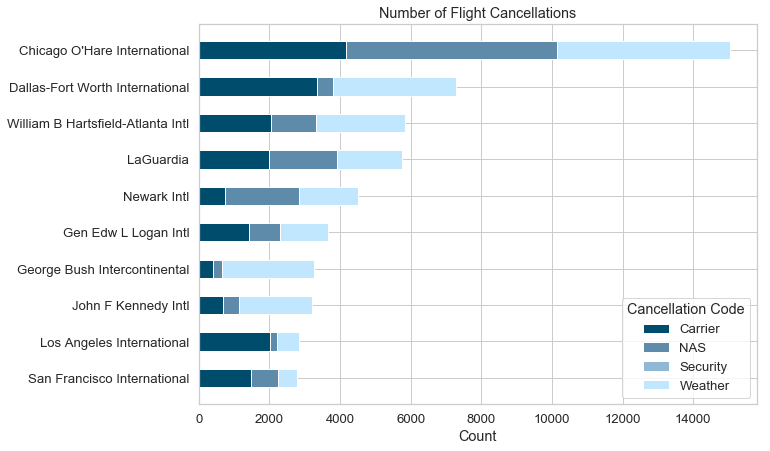

In [67]:
plot_cancel_code('airport_origin')

### Which airlines have the high number of flight cancellations?

Of all the airlines, American Eagle and American Airlines have the most cancellations.  If you look at the cancellation due to carrier (within the airline's control), you will see that American Airlies is on the top of the list.  Even though American Eagle has the most cancellations, only about 15% is within their control.  Whereas for #2 American Airlines we see that carrier cancellation accounts for about 60% of its cancellations.  Southwest and United also have high percentage of carrier cancellations at 50% or more.. Of course there are also other factors that causes cancellation that are out of the control of airlines, such as NAS, security, and weather.



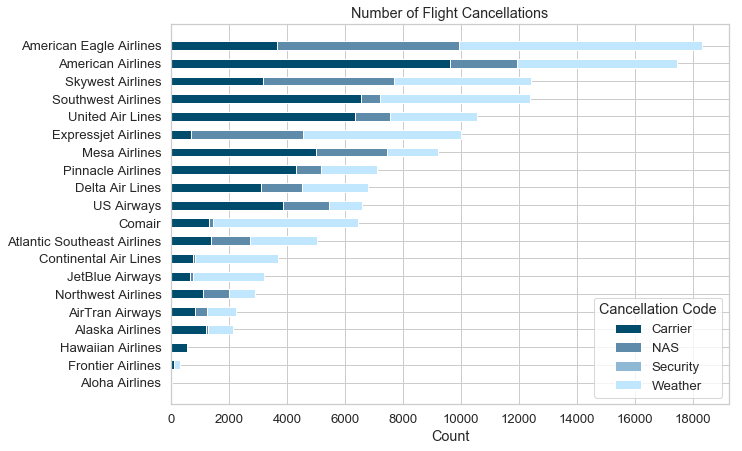

In [68]:
plot_cancel_code('Airline',df_08.Airline.value_counts().shape[0])

### What are the best and worst months to fly in terms of cancellations?

You're least likely to experience a flight cancellation dueing the months of October and November, while the winter months tops the list, and certainly most of it due to weather!

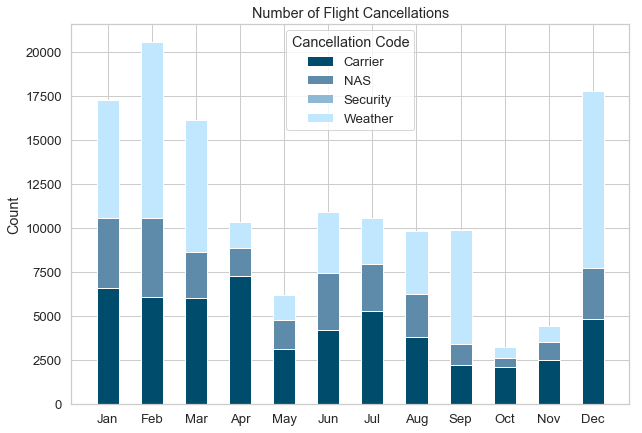

In [69]:
plot_cancel_code('Month',df_08.Month.value_counts().shape[0],sorted=False,orientation='v')

### Which states experience the most cancellations?

Illinois, Texas, and California round out the top 3, followed by New York.  I'd say it's probably due to the large number of flights that these states have.

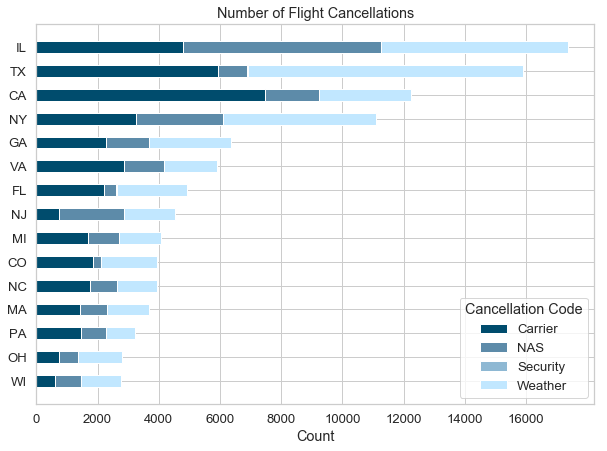

In [70]:
plot_cancel_code('origin_state',15)

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!